In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

In [5]:
os.chdir(r'C:\Users\Guillaume Capelli\Desktop\Ironhack_189\Final_Project')

# Load each file into a pandas DataFrame
sample_submission_df = pd.read_csv(r'Dataset\Kaggle\sample_submission.csv')
test_df = pd.read_csv(r'Dataset\Kaggle\test.csv')
test_labels_df = pd.read_csv(r'Dataset\Kaggle\test_labels.csv')
train_df = pd.read_csv(r'Dataset\Kaggle\train.csv')

In [6]:
# Preview the first few rows of each DataFrame
dfs_preview = {
    "sample_submission": sample_submission_df.head(),
    "test": test_df.head(),
    "test_labels": test_labels_df.head(),
    "train": train_df.head()
}

dfs_preview

{'sample_submission':                  id  toxic  severe_toxic  obscene  threat  insult  \
 0  00001cee341fdb12    0.5           0.5      0.5     0.5     0.5   
 1  0000247867823ef7    0.5           0.5      0.5     0.5     0.5   
 2  00013b17ad220c46    0.5           0.5      0.5     0.5     0.5   
 3  00017563c3f7919a    0.5           0.5      0.5     0.5     0.5   
 4  00017695ad8997eb    0.5           0.5      0.5     0.5     0.5   
 
    identity_hate  
 0            0.5  
 1            0.5  
 2            0.5  
 3            0.5  
 4            0.5  ,
 'test':                  id                                       comment_text
 0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
 1  0000247867823ef7  == From RfC == \r\n\r\n The title is fine as i...
 2  00013b17ad220c46  " \r\n\r\n == Sources == \r\n\r\n * Zawe Ashto...
 3  00017563c3f7919a  :If you have a look back at the source, the in...
 4  00017695ad8997eb          I don't anonymously edit articles at a

In [7]:
# Summarize the shape and data types of each DataFrame
data_summaries = {
    "sample_submission_shape": sample_submission_df.shape,
    "test_shape": test_df.shape,
    "test_labels_shape": test_labels_df.shape,
    "train_shape": train_df.shape,
    "sample_submission_dtypes": sample_submission_df.dtypes,
    "test_dtypes": test_df.dtypes,
    "test_labels_dtypes": test_labels_df.dtypes,
    "train_dtypes": train_df.dtypes,
    "train_describe": train_df.describe(),
    "missing_values": {
        "sample_submission_missing": sample_submission_df.isnull().sum(),
        "test_missing": test_df.isnull().sum(),
        "test_labels_missing": test_labels_df.isnull().sum(),
        "train_missing": train_df.isnull().sum()
    }
}

data_summaries

{'sample_submission_shape': (153164, 7),
 'test_shape': (153164, 2),
 'test_labels_shape': (153164, 7),
 'train_shape': (159571, 8),
 'sample_submission_dtypes': id                object
 toxic            float64
 severe_toxic     float64
 obscene          float64
 threat           float64
 insult           float64
 identity_hate    float64
 dtype: object,
 'test_dtypes': id              object
 comment_text    object
 dtype: object,
 'test_labels_dtypes': id               object
 toxic             int64
 severe_toxic      int64
 obscene           int64
 threat            int64
 insult            int64
 identity_hate     int64
 dtype: object,
 'train_dtypes': id               object
 comment_text     object
 toxic             int64
 severe_toxic      int64
 obscene           int64
 threat            int64
 insult            int64
 identity_hate     int64
 dtype: object,
 'train_describe':                toxic   severe_toxic        obscene         threat  \
 count  159571.000000  159571

In [8]:
# Calculate the sum of each label type to understand the distribution
label_sums = train_df.iloc[:, 2:].sum().sort_values(ascending=False)
label_sums 

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

In [9]:
#Create an additional category for comments with no toxic labels
train_df['non_toxic'] = (train_df.iloc[:, 2:].sum(axis=1) == 0).astype(int)

# Calculate the sum of each label type again, including the 'non_toxic' category
label_sums_with_non_toxic = train_df.iloc[:, 2:].sum().sort_values(ascending=False)

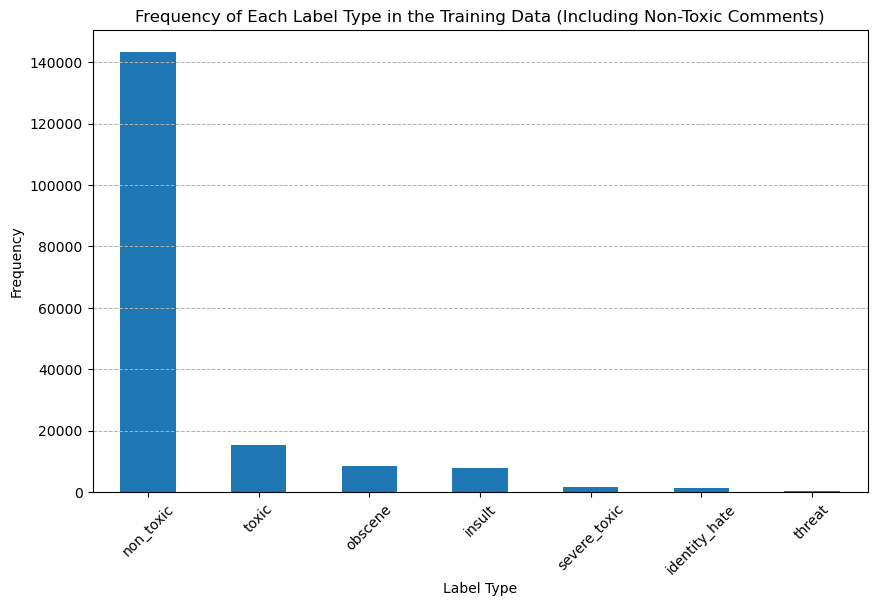

In [10]:
plt.figure(figsize=(10, 6))
label_sums_with_non_toxic.plot(kind='bar')
plt.title('Frequency of Each Label Type in the Training Data (Including Non-Toxic Comments)')
plt.xlabel('Label Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

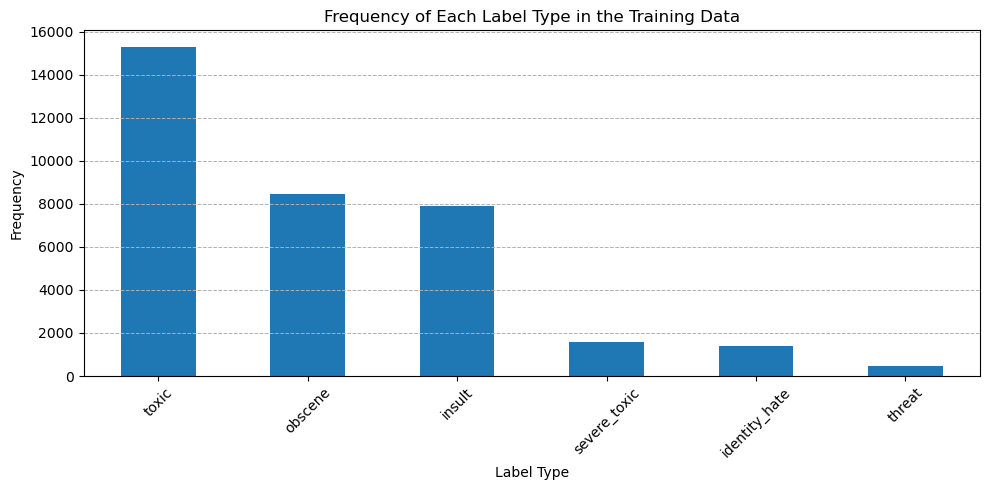

In [10]:
# Create a bar plot for the label frequency
plt.figure(figsize=(10,5))
label_sums.plot(kind='bar')
plt.title('Frequency of Each Label Type in the Training Data')
plt.xlabel('Label Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout() # Adjust the plot to ensure everything fits without overlapping
plt.show()

In [11]:
# Renaming 'comment_text' column to 'comment' in all DataFrames that have this column
train_df.rename(columns={'comment_text': 'comment'}, inplace=True)
test_df.rename(columns={'comment_text': 'comment'}, inplace=True)

In [15]:
test_df['comment'] = test_df['comment'].str.replace('[^\w\s]', '', regex=True)
train_df['comment'] = train_df['comment'].str.replace('[^\w\s]', '', regex=True)

In [19]:
# Add a 'comment_length' column to the test and train DataFrames
test_df['comment_length'] = test_df['comment'].apply(len)
train_df['comment_length'] = train_df['comment'].apply(len)

In [27]:
# Define bins for comment length categories
bins = [0, 50, 100, 200, 500, 1000, 2000, train_df['comment_length'].max()]
train_df['length_category'] = pd.cut(train_df['comment_length'], bins=bins)

# Group by length category and calculate distribution
distribution = train_df.groupby('length_category')['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'].sum()

# Calculate the total number of comments in each bin for normalization
total_comments_by_length = train_df['length_category'].value_counts().reindex(distribution.index)

# Convert counts to percentages by dividing by the total and multiplying by 100
distribution_percentage = (distribution.T / total_comments_by_length).T * 100

# Display the distribution percentages
distribution_percentage

C:\Users\Guillaume\AppData\Local\Temp\ipykernel_20088\1927100234.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  distribution = train_df.groupby('length_category')['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'].sum()


,toxic,severe_toxic,obscene,threat,insult,identity_hate
length_category,,,,,,
"(0, 50]",16.854900,2.324639,10.863510,0.425424,9.577108,1.610534
"(50, 100]",14.062247,1.629113,7.869995,0.518723,7.533636,1.406225
"(100, 200]",9.738177,0.880055,5.121316,0.356408,4.970528,0.841672
"(200, 500]",6.921928,0.452371,3.471786,0.203459,3.313781,0.577910
"(500, 1000]",5.265800,0.321269,2.610311,0.110436,2.389438,0.496963
"(1000, 2000]",4.198430,0.364091,1.934236,0.068267,1.627034,0.352714
"(2000, 5000]",8.714134,2.869288,5.313496,0.371945,4.357067,0.956429


In [20]:
train_df

,id,comment,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,254
1,000103f0d9cfb60f,Daww He matches this background colour Im seem...,0,0,0,0,0,0,100
2,000113f07ec002fd,Hey man Im really not trying to edit war Its j...,0,0,0,0,0,0,227
3,0001b41b1c6bb37e,\nMore\nI cant make any real suggestions on im...,0,0,0,0,0,0,603
4,0001d958c54c6e35,You sir are my hero Any chance you remember wh...,0,0,0,0,0,0,62
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,And for the second time of asking when your vi...,0,0,0,0,0,0,277
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,95
159568,ffee36eab5c267c9,Spitzer \n\nUmm theres no actual article for p...,0,0,0,0,0,0,77
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,115


In [21]:
test_df

,id,comment,comment_length
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then youll ...,355
1,0000247867823ef7,From RfC \n\n The title is fine as it is IMO,44
2,00013b17ad220c46,\n\n Sources \n\n Zawe Ashton on Lapland,45
3,00017563c3f7919a,If you have a look back at the source the info...,199
4,00017695ad8997eb,I dont anonymously edit articles at all,39
...,...,...,...
153159,fffcd0960ee309b5,\n i totally agree this stuff is nothing but ...,56
153160,fffd7a9a6eb32c16,Throw from out field to home plate \n\n Does...,191
153161,fffda9e8d6fafa9e,\n\n Okinotorishima categories \n\n I see y...,387
153162,fffe8f1340a79fc2,\n\n One of the founding nations of the EU ...,469


In [22]:
test_df.to_csv(r'Data Cleaning\Kaggle\test_clean.csv', index=False)
train_df.to_csv(r'Data Cleaning\Kaggle\train_clean.csv', index=False)
test_labels_df.to_csv(r'Data Cleaning\Kaggle\test_labels_clean.csv', index=False)
sample_submission_df.to_csv(r'Data Cleaning\Kaggle\sample_submission_clean.csv', index=False)

In [24]:
pw = os.getenv('MySQL_password')
connection_string = 'mysql+pymysql://root:' + pw + '@localhost:3306/'
engine = create_engine(connection_string)

# Upload each DataFrame to its respective table in the MySQL database
test_df.to_sql(name='test_comments', con=engine, schema='comment_toxicity', if_exists='replace', index=False)
train_df.to_sql(name='train_comments', con=engine, schema='comment_toxicity', if_exists='replace', index=False)
test_labels_df.to_sql(name='test_labels', con=engine, schema='comment_toxicity', if_exists='replace', index=False)
sample_submission_df.to_sql(name='sample_submissions', con=engine, schema='comment_toxicity', if_exists='replace', index=False)

153164